# Convolutional Autoencoder

In [0]:
%matplotlib inline

import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [0]:
features = np.empty((0,32,32,3))
labels = []
for i in range(1, 6):
    ft, lb = load_cifar10_batch('./', i)
    features = np.concatenate((features, ft))
    labels += lb
x_train = features / 255

In [0]:
ft, lb = load_cifar10_batch('./', 6)
x_test = ft / 255

In [21]:
print (x_train.shape)
print (len(labels))

(50000, 32, 32, 3)
50000


In [22]:
print (x_test.shape)

(10000, 32, 32, 3)


Label: 7


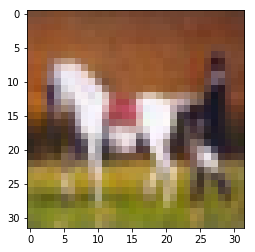

In [23]:
idx = random.randint(1, len(labels))
print ("Label: {}".format(labels[idx]))
img = x_train[idx]
plt.imshow(img.reshape((32, 32, 3)))

In [25]:
learning_rate = 0.001
# Input and target placeholders

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv1.shape)
# Now 32x32x64
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
print(maxpool1.shape)
# Now 16x16x64
conv2 = tf.layers.conv2d(maxpool1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv2.shape)
# Now 16x16x128
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
print(maxpool2.shape)
# Now 8x8x128
conv3 = tf.layers.conv2d(maxpool2, 256, (3,3), padding='same', activation=tf.nn.relu)
print(conv3.shape)
# Now 8x8x256
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(encoded.shape)
# Now 4x4x256

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (8,8))
print(upsample1.shape)
# Now 8x8x256
conv4 = tf.layers.conv2d(upsample1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.shape)
# Now 8x8x128
upsample2 = tf.image.resize_nearest_neighbor(conv4, (16,16))
print(upsample2.shape)
# Now 16x16x128
conv5 = tf.layers.conv2d(upsample2, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv5.shape)
# Now 16x16x64
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
print(upsample3.shape)
# Now 32x32x64
logits = tf.layers.conv2d(upsample3, 3, (3,3), padding='same', activation=None)
print(logits.shape)
# Now 32x32x3

#logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#print(logits.shape)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?, 32, 32, 64)
(?, 16, 16, 64)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 8, 8, 256)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 16, 16, 64)
(?, 32, 32, 64)
(?, 32, 32, 3)


## Training

In [0]:
sess = tf.Session()

In [0]:
def get_batch(ii, batch_size):
    begin = ii * batch_size
    end = (ii+1) * batch_size
    return x_train[begin:end], labels[begin:end]

In [28]:
epochs = 20
train_size = features.shape[0]
batch_size = 128
total_batches = train_size//batch_size

sess.run(tf.global_variables_initializer())
for e in range(epochs):    
    for ii in range(total_batches):
        batch = get_batch(ii, batch_size)
        imgs = batch[0].reshape((-1, 32, 32, 3))        
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        if ii % 100 == 0:
            print("Epoch: {}/{} Step: {}/{} ...".format(e+1, epochs, ii, total_batches),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20 Step: 0/390 ... Training loss: 0.6934
Epoch: 1/20 Step: 100/390 ... Training loss: 0.5703
Epoch: 1/20 Step: 200/390 ... Training loss: 0.5710
Epoch: 1/20 Step: 300/390 ... Training loss: 0.5710
Epoch: 2/20 Step: 0/390 ... Training loss: 0.5761
Epoch: 2/20 Step: 100/390 ... Training loss: 0.5555
Epoch: 2/20 Step: 200/390 ... Training loss: 0.5634
Epoch: 2/20 Step: 300/390 ... Training loss: 0.5644
Epoch: 3/20 Step: 0/390 ... Training loss: 0.5688
Epoch: 3/20 Step: 100/390 ... Training loss: 0.5506
Epoch: 3/20 Step: 200/390 ... Training loss: 0.5597
Epoch: 3/20 Step: 300/390 ... Training loss: 0.5624
Epoch: 4/20 Step: 0/390 ... Training loss: 0.5666
Epoch: 4/20 Step: 100/390 ... Training loss: 0.5486
Epoch: 4/20 Step: 200/390 ... Training loss: 0.5568
Epoch: 4/20 Step: 300/390 ... Training loss: 0.5618
Epoch: 5/20 Step: 0/390 ... Training loss: 0.5652
Epoch: 5/20 Step: 100/390 ... Training loss: 0.5475
Epoch: 5/20 Step: 200/390 ... Training loss: 0.5569
Epoch: 5/20 Step: 300/

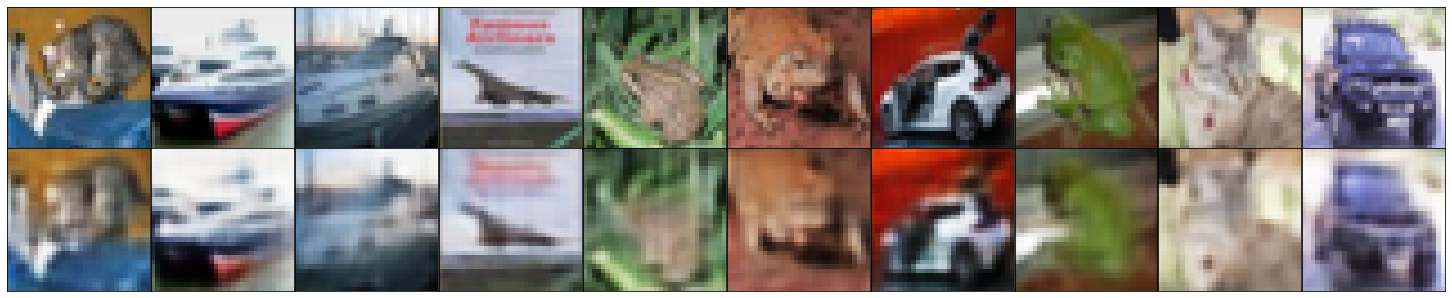

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 32, 32, 3))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [0]:
sess.close()

## Denoising

In [31]:
learning_rate = 0.001

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv1.shape)
# Now 32x32x64
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
print(maxpool1.shape)
# Now 16x16x64
conv2 = tf.layers.conv2d(maxpool1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv2.shape)
# Now 16x16x128
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
print(maxpool2.shape)
# Now 8x8x128
conv3 = tf.layers.conv2d(maxpool2, 256, (3,3), padding='same', activation=tf.nn.relu)
print(conv3.shape)
# Now 8x8x256
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
print(encoded.shape)
# Now 4x4x256

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (8,8))
print(upsample1.shape)
# Now 8x8x256
conv4 = tf.layers.conv2d(upsample1, 128, (3,3), padding='same', activation=tf.nn.relu)
print(conv4.shape)
# Now 8x8x128
upsample2 = tf.image.resize_nearest_neighbor(conv4, (16,16))
print(upsample2.shape)
# Now 16x16x128
conv5 = tf.layers.conv2d(upsample2, 64, (3,3), padding='same', activation=tf.nn.relu)
print(conv5.shape)
# Now 16x16x64
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
print(upsample3.shape)
# Now 32x32x64
logits = tf.layers.conv2d(upsample3, 3, (3,3), padding='same', activation=None)
print(logits.shape)
# Now 32x32x3

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

(?, 32, 32, 64)
(?, 16, 16, 64)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 8, 8, 256)
(?, 4, 4, 256)
(?, 8, 8, 256)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 16, 16, 64)
(?, 32, 32, 64)
(?, 32, 32, 3)


In [0]:
sess = tf.Session()

In [36]:
epochs = 20
batch_size = 128
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.2
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(total_batches):
        batch = get_batch(ii, batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 32, 32, 3))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        if ii % 100 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6944
Epoch: 1/20... Training loss: 0.5747
Epoch: 1/20... Training loss: 0.5749
Epoch: 1/20... Training loss: 0.5751
Epoch: 2/20... Training loss: 0.5794
Epoch: 2/20... Training loss: 0.5596
Epoch: 2/20... Training loss: 0.5667
Epoch: 2/20... Training loss: 0.5692
Epoch: 3/20... Training loss: 0.5742
Epoch: 3/20... Training loss: 0.5558
Epoch: 3/20... Training loss: 0.5636
Epoch: 3/20... Training loss: 0.5668
Epoch: 4/20... Training loss: 0.5716
Epoch: 4/20... Training loss: 0.5543
Epoch: 4/20... Training loss: 0.5623
Epoch: 4/20... Training loss: 0.5656
Epoch: 5/20... Training loss: 0.5706
Epoch: 5/20... Training loss: 0.5567
Epoch: 5/20... Training loss: 0.5612
Epoch: 5/20... Training loss: 0.5645
Epoch: 6/20... Training loss: 0.5699
Epoch: 6/20... Training loss: 0.5521
Epoch: 6/20... Training loss: 0.5605
Epoch: 6/20... Training loss: 0.5641
Epoch: 7/20... Training loss: 0.5690
Epoch: 7/20... Training loss: 0.5515
Epoch: 7/20... Training loss: 0.5624
E

## Checking out the performance

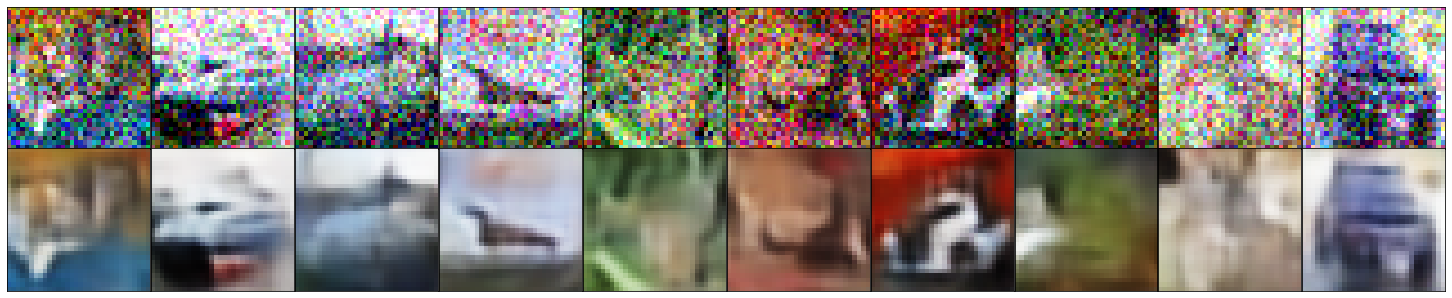

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = x_test[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 32, 32, 3))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)